In [2]:
import torch 
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class Discriminator(nn.Module):
  def __init__(self,channels_img,features_d):
    super(Discriminator,self).__init__()
    self.disc=nn.Sequential(
      nn.Conv2d(channels_img,features_d,kernel_size=4,stride=2,padding=1),
      nn.LeakyReLU(0.2),
      self.block(features_d,features_d*2,4,2,1),
      self.block(features_d*2,features_d*4,4,2,1),
      self.block(features_d*4,features_d*8,4,2,1),
      nn.Conv2d(features_d*8,1,4,2,0),
      nn.Sigmoid()
    )
  def block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)

    )
  def forward(self,x):
    return self.disc(x)
  

In [4]:
class Generator(nn.Module):
  def __init__(self,z_dim,channels_img,features_g):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
      self.block(z_dim,features_g*16,4,1,0),
      self.block(features_g*16,features_g*8,4,2,1),
      self.block(features_g*8,features_g*4,4,2,1),
      self.block(features_g*4,features_g*2,4,2,1),
      nn.ConvTranspose2d(features_g*2,channels_img,4,2,1),
      nn.Tanh()
    )
  def block(self,in_channels,out_channels,kernel_size,stride,padding):
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
  def forward(self,x):
    return self.gen(x)

In [5]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data,0.0,0.02)
    

In [6]:
device=torch.device("cuda")
learning_rate=2e-4
batch_size=128
image_size=64
channels_img=1
z_dim=100
epochs=5
features_d=64
features_g=64

In [7]:
transforms=transforms.Compose([
  transforms.Resize(image_size),
  transforms.ToTensor(),
  transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)])

])


In [8]:
dataset=torchvision.datasets.MNIST(root='./data',train=True,transform=transforms)
loader=DataLoader(dataset,batch_size=128,shuffle=True)


In [9]:
gen=Generator(z_dim,channels_img,features_g).to(device)
disc=Discriminator(channels_img,features_d).to(device)
initialize_weights(gen)
initialize_weights(disc)


In [10]:
gen_optim=optim.Adam(gen.parameters(),lr=learning_rate,betas=(0.5,0.999))
disc_optim=optim.Adam(disc.parameters(),lr=learning_rate,betas=(0.5,0.999))
criterion=nn.BCELoss()

In [11]:
fixed_noise=torch.randn(32,z_dim,1,1).to(device)
gen.train()
disc.train()


Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

Epoch [1/5]: 100%|██████████| 469/469 [13:14<00:00,  1.69s/it, D_loss=0.896, G_loss=0.611]


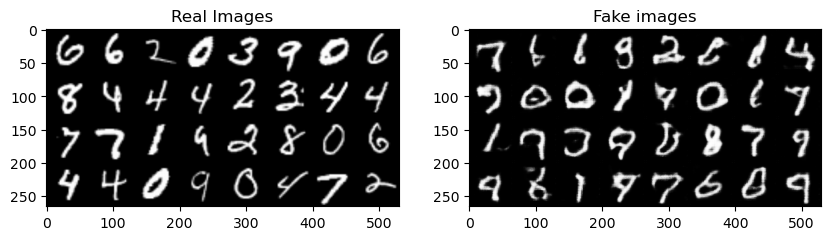

Epoch [2/5]: 100%|██████████| 469/469 [23:49<00:00,  3.05s/it, D_loss=0.593, G_loss=1.39] 


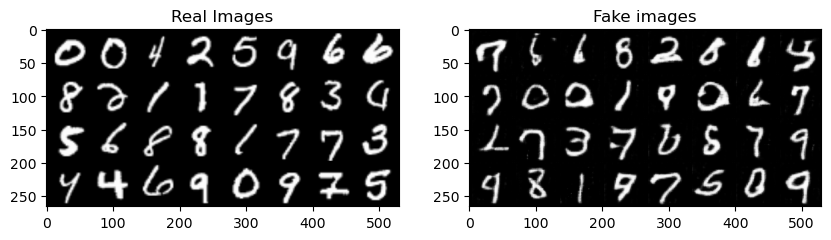

Epoch [3/5]: 100%|██████████| 469/469 [51:40<00:00,  6.61s/it, D_loss=0.721, G_loss=0.875]


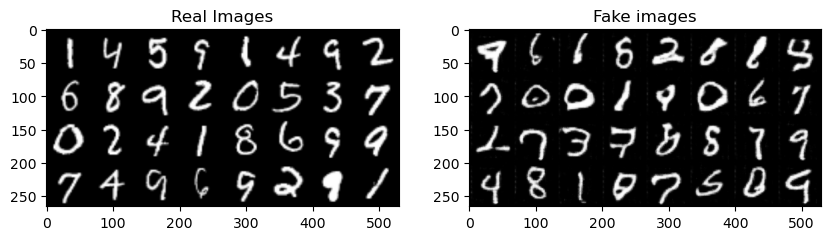

Epoch [4/5]: 100%|██████████| 469/469 [19:08<00:00,  2.45s/it, D_loss=0.577, G_loss=3.32] 


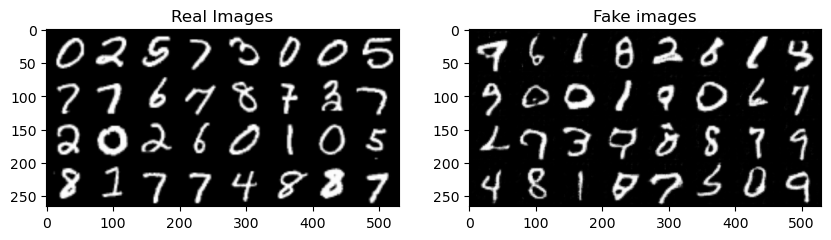

Epoch [5/5]: 100%|██████████| 469/469 [20:36<00:00,  2.64s/it, D_loss=0.413, G_loss=1.32]


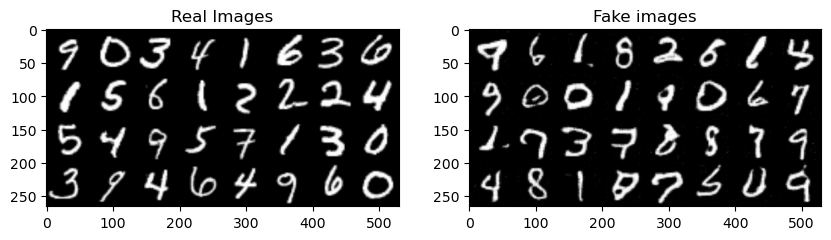

In [14]:
for epoch in range(epochs):
  loop=tqdm(loader,leave=True)
  for batch_size,(real,_) in enumerate(loop):
    real=real.to(device)
    noise=torch.randn(batch_size,z_dim,1,1).to(device)

    fake=gen(noise)
    disc_real=disc(real).reshape(-1)
    disc_fake=disc(fake).reshape(-1)

    disc_real_loss=criterion(disc_real,torch.ones_like(disc_real))
    disc_fake_loss=criterion(disc_fake,torch.zeros_like(disc_fake))
    disc_loss=disc_real_loss+disc_fake_loss/2
    disc_optim.zero_grad()
    disc_loss.backward(retain_graph=True)
    disc_optim.step()

    output=disc(fake).reshape(-1)
    gen_loss=criterion(output,torch.ones_like(output))

    gen_optim.zero_grad()
    gen_loss.backward()
    gen_optim.step()
    if batch_size % 100 == 0:
      loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
      loop.set_postfix(D_loss=disc_loss.item(), G_loss=gen_loss.item())
  with torch.no_grad():
    fake=gen(fixed_noise).detach().cpu()
  img_grid_real=torchvision.utils.make_grid(real[:32].cpu(),normalize=True)
  img_grid_fake=torchvision.utils.make_grid(fake[:32],normalize=True)

  def show_images(real_img,fake_img):
    fig=plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Real Images")
    plt.imshow(real_img.permute(1,2,0).cpu().numpy())

    plt.subplot(1,2,2)
    plt.title("Fake images")
    plt.imshow(fake_img.permute(1,2,0).cpu().numpy())
    plt.show()
  show_images(img_grid_real,img_grid_fake)

In [ ]:
def generate_and_display_image(gen,z_dim,device):
  gen.eval()
  noise=torch.randn(1,z_dim,1,1).to(device)
  with torch.no_grad():
    fake_image=gen(noise).cpu()
  img_grid=torchvision.utils.make_grid(fake_image,normalize=True)
  img_grid=img_grid.permute(1,2,0).numpy()
  plt.figure(figsize=(5,5))
  plt.imshow(img_grid,cmap="gray")
  plt.title("Generated Image")
  plt.axis("off")
  plt.show()
z_dim=100
generate_and_display_image(gen, z_dim, device)
